In [5]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
import torch
from transformers import (
    AutoTokenizer
)

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load time series

In [1]:
from llmicl.rl_helpers.rl_utils import load_offline_dataset, create_env

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [183]:
env_name = 'HalfCheetah'
context_length = 400
dataset = 'expert'  # 'expert_80k_20k'
episode = 2

_, n_observations, n_actions = create_env(env_name)

data_path = f"/home/abenechehab/datasets/{env_name}/{dataset}/X_test.csv"
X = load_offline_dataset(path=data_path)

# find episodes beginnings
restart_index = n_observations+n_actions+1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

print(f"episode starts: {episode_starts}")

init_index = episode_starts[episode]

time_series = X[init_index:init_index+context_length, :n_observations]

episode starts: [    0     1     2 ... 18997 18998 18999]


/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


# rescale + serialize

In [187]:
dim = 14
prediction_horizon = 50
tsr = X[init_index:init_index+context_length+prediction_horizon, dim]
normalized = (tsr-min(tsr))/(max(tsr)-min(tsr)) * 9.0 + 0.5
normalized_r = np.round(normalized, decimals=3)
normalized_str = ''
for i in range(context_length):
    normalized_str += str(int(normalized_r[i]*100))
    normalized_str += ','

## Main code: call openai api

In [188]:
# !pip install -U openai
from openai import OpenAI
from transformers import AutoTokenizer

client = OpenAI(
    # base_url="http://10.155.97.225:4000/v1",
    base_url='http://10.227.91.60:4000/v1',  # For European Research Institue
    api_key="sk-1234",
)

chatgpt_sys_message = "You are a statistical and analytical assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:\n"
# fibo_series = "1,1,2,3,5,8,13,21,34"

tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/"
    "62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)

good_tokens_str = [","]
for num in range(1000):
    good_tokens_str.append(str(num))
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]

predictions_llms = {}
for model in ["llama-3.1-70b-instruct",]:  # "llama-3-8b-instruct", ]:
    for prompt in [True, False]:
        # chat with llm
        stream = client.chat.completions.create(
            model=model,
            messages=[
                # {"role": "system", "content": chatgpt_sys_message},
                {"role": "user", "content": extra_input + normalized_str[:-1] if prompt else normalized_str[:-1]},
                # {"role": "user", "content": normalized_str[:-1]},
            ],
            temperature=0,
            stream=True,
            max_tokens=prediction_horizon*2-1,
            logit_bias={id: 100 for id in good_tokens},
        )
        
        full_response = ''
        for chunk in stream:
            try:
                full_response += chunk.choices[0].delta.content
                # full_response += ','
            except TypeError:
                pass
        print(f"raw response: {full_response}\n")
        key = model + "+prompt" if prompt else model
        predictions_llms[key] = np.array([int(e)/100 for e in full_response.split(',') if e != ''])
        print(f"model: {key}\n full_response: {predictions_llms[key]}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


raw response: 667,555,446,83,504,882,623,555,446,74,504,882,623,555,446,83,504,882,623,555,446,74,504,882,623,555,446,83,504,882,623,555,446,74,504,882,623,555,446,83,504,882,623,555,446,74,504,882,623,555

model: llama-3.1-70b-instruct+prompt
 full_response: [6.67 5.55 4.46 0.83 5.04 8.82 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55
 4.46 0.83 5.04 8.82 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55 4.46 0.83
 5.04 8.82 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55 4.46 0.83 5.04 8.82
 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55]
raw response: 553,571,310,293,506,562,653,654,443,311,383,511,503,606,616,663,449,252,313,567,567,563,687,595,599,439,332,254,490,735,616,536,333,281,475,551,611,629,633,380,344,359,542,691,505,700,371,216,375,600

model: llama-3.1-70b-instruct
 full_response: [5.53 5.71 3.1  2.93 5.06 5.62 6.53 6.54 4.43 3.11 3.83 5.11 5.03 6.06
 6.16 6.63 4.49 2.52 3.13 5.67 5.67 5.63 6.87 5.95 5.99 4.39 3.32 2.54
 4.9  7.35 6.16 5.36 3.33 2.81 4.75 5.51 6.11 6.29 6.33 3.8  3.44 3.59
 5.42 6.91 

## Visualization

llama-3.1-70b-instruct+prompt
llama-3.1-70b-instruct


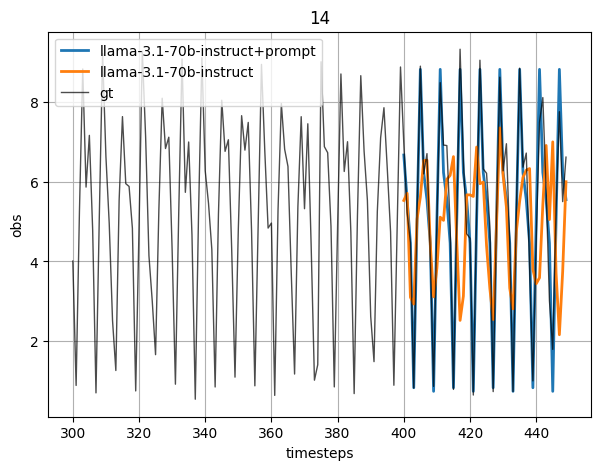

In [189]:
start_from = 300
f, axes = plt.subplots(1, 1, figsize=(7, 5), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
ax = axes[0]

# -------------------- Trajectory visualization --------------------
x = np.arange(len(normalized_r))
# multi_step
for model in predictions_llms.keys():
    print(model)
    if -prediction_horizon+len(predictions_llms[model]) != 0:
        ax.plot(
            x[-prediction_horizon:-prediction_horizon+len(predictions_llms[model])], 
            predictions_llms[model], 
            label=model,
            linewidth=2
        )
    else:
        ax.plot(x[-prediction_horizon:], predictions_llms[model], label=model, linewidth=2)

ax.plot(x[start_from:], normalized_r[start_from:], label='gt', color='black', alpha=.7, linewidth=1)
ax.set_title(f"{dim}")
ax.set_xlabel("timesteps")
ax.set_ylabel("obs")

ax.legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
ax.grid(True)
plt.show()